In [1]:
import pandas as pd

import time

import datetime

import numpy as np

import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [43]:
pd.options.display.max_columns = 30
pd.options.display.max_rows= 5

In [3]:
df = pd.read_csv("rb1905.csv",usecols=['date_time','newest_price','buy_v1','sell_v1'])
df.date_time = pd.to_datetime(df.date_time)
df.set_index(['date_time'],inplace=True)

In [4]:
class df_model:
    def __init__(self,raw_data):
        self.data = raw_data
    
    
    def add_factor(self,var_name,src_data):
        temp_data = self.data.copy()
        temp_data[var_name] = src_data
        self.data = temp_data
        return temp_data
    
    
    def add_target(self,target_name,src_data):
        temp_data = self.data.copy()
        temp_data[target_name] = src_data
        self.data = temp_data
        return temp_data
    
    
    def dropnull(self):
        return self.data.dropna(inplace=True)

In [5]:
def predictor_normalizaiton(df,col):
    return ((df[col] - df[col].mean())/(df[col].max() - df[col].min()))

In [78]:
df_model1 = df_model(df[['newest_price','buy_v1','sell_v1']])

In [79]:
df_model1.data = df_model1.data.resample('1T').mean()

In [80]:
df_model1.data

,newest_price,buy_v1,sell_v1
date_time,,,
2018-10-08 08:59:00,3712.000000,1.000000,10.000000
2018-10-08 09:00:00,3715.537815,16.470588,41.210084
...,...,...,...
2018-12-28 22:59:00,3393.400000,246.025000,139.316667
2018-12-28 23:00:00,3392.000000,10.000000,147.000000


In [88]:
df_model1.data.newest_price.rolling(200).mean()

date_time
2018-10-08 08:59:00   NaN
2018-10-08 09:00:00   NaN
                       ..
2018-12-28 22:59:00   NaN
2018-12-28 23:00:00   NaN
Freq: T, Name: newest_price, Length: 117482, dtype: float64

In [83]:
df_model1.data.newest_price - df_model1.data.newest_price.rolling(200).mean()

date_time
2018-10-08 08:59:00   NaN
2018-10-08 09:00:00   NaN
                       ..
2018-12-28 22:59:00   NaN
2018-12-28 23:00:00   NaN
Freq: T, Name: newest_price, Length: 117482, dtype: float64

In [75]:
df_model1.add_factor('Price_Minus_MeanPrice',df_model1.data.newest_price - df_model1.data.newest_price.rolling(200).mean())
df_model1.add_factor('Buy_Minus_Sell',(df_model1.data.buy_v1 - df_model1.data.sell_v1).rolling(200).mean())
df_model1.add_factor('Moving_Avg_Return',df_model1.data.newest_price.diff().rolling(200).mean())
# df_model1.add_factor('vsma2',df_model1.data.vol.rolling(v2).mean())

,newest_price,buy_v1,sell_v1,Price_Minus_MeanPrice,Buy_Minus_Sell,Moving_Avg_Return
date_time,,,,,,
2018-10-08 08:59:00,3712.000000,1.000000,10.000000,NaN,NaN,NaN
2018-10-08 09:00:00,3715.537815,16.470588,41.210084,NaN,NaN,NaN
...,...,...,...,...,...,...
2018-12-28 22:59:00,3393.400000,246.025000,139.316667,NaN,NaN,NaN
2018-12-28 23:00:00,3392.000000,10.000000,147.000000,NaN,NaN,NaN


In [69]:
df_model1.add_factor('Price_Minus_MeanPrice_norm',predictor_normalizaiton(df_model1.data,'Price_Minus_MeanPrice'))
df_model1.add_factor('Buy_Minus_Sell_norm',predictor_normalizaiton(df_model1.data,'Buy_Minus_Sell'))
df_model1.add_factor('Moving_Avg_Return_norm',predictor_normalizaiton(df_model1.data,'Moving_Avg_Return'))
# df_model1.add_factor('vsma2_norm',predictor_normalizaiton(df_model1.data,'vsma2'))


df_model1.add_target('future_return',df_model1.data.newest_price.pct_change(200))
# 计算五天后的收益率

df_model1.dropnull()

In [77]:
df_model1.data.dropna()

,newest_price,buy_v1,sell_v1,Price_Minus_MeanPrice,Buy_Minus_Sell,Moving_Avg_Return
date_time,,,,,,


In [70]:
df_model1.data.newest_price.plot(figsize=(20,5),grid=True)

TypeError: Empty 'DataFrame': no numeric data to plot

In [61]:
time_low = datetime.datetime(year=2018,month=10,day=9)
time_mid = datetime.datetime(year=2018,month=11,day=12)
time_up = datetime.datetime(year=2018,month=12,day=20)

In [62]:
in_sample = df_model1.data[(df_model1.data.index<time_mid)&(df_model1.data.index>time_low)]
in_sample

,newest_price,buy_v1,sell_v1,Price_Minus_MeanPrice,Buy_Minus_Sell,Moving_Avg_Return,Price_Minus_MeanPrice_norm,Buy_Minus_Sell_norm,Moving_Avg_Return_norm,future_return
date_time,,,,,,,,,,


In [63]:
out_sample = df_model1.data[(df_model1.data.index<time_up)&(df_model1.data.index>time_mid)]
out_sample

,newest_price,buy_v1,sell_v1,Price_Minus_MeanPrice,Buy_Minus_Sell,Moving_Avg_Return,Price_Minus_MeanPrice_norm,Buy_Minus_Sell_norm,Moving_Avg_Return_norm,future_return
date_time,,,,,,,,,,


In [64]:
def knn_predictor(insample,insample_col,single_outsample,knn=5):
    all_dist = np.sqrt(np.sum(np.square(\
                         insample[insample_col].values\
                         - single_outsample),axis=1))
    dist_index = all_dist.argsort()[:knn]
    return insample.iloc[dist_index]['future_return'].mean()
# 要return的是后面的future return 的mean，而不是distance的return
# --------------------------------------------------------------------------
variable = ['Price_Minus_MeanPrice','Buy_Minus_Sell','Moving_Avg_Return']

predict = []

for sub_out_sample in out_sample.index[:]:
    row = out_sample[out_sample.index == sub_out_sample]
    outsample_factor = row[variable].values[0]
    predict.append(knn_predictor(insample=in_sample,insample_col=variable,single_outsample=outsample_factor,knn=5))
# --------------------------------------------------------------------------
temp_out_sample = out_sample.copy()
temp_out_sample['prediction'] = pd.Series(predict,index=out_sample.index)
out_sample = temp_out_sample

In [66]:
out_sample[['future_return','prediction']].plot(figsize=(30,5),grid=True)

TypeError: Empty 'DataFrame': no numeric data to plot

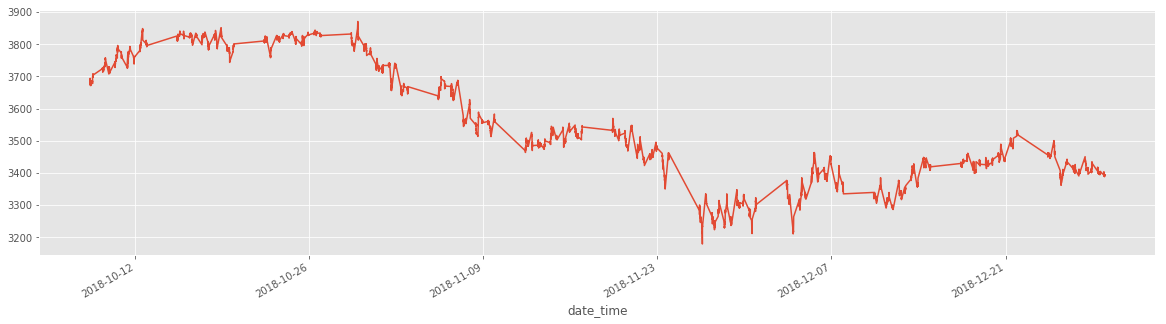

In [47]:
df_model1.data.newest_price.plot(figsize=(20,5),grid=True)

In [ ]:
def signal_rule(x):
    if x > 0.05:
        return 1
    elif x < -0.03:
        return -1
    else:
        return 0

temp_out_sample = out_sample.copy()
temp_out_sample['signal'] = temp_out_sample.prediction.apply(signal_rule)
out_sample = temp_out_sample